<a href="https://colab.research.google.com/github/gnidetsanna/python_for_ML_tasks/blob/main/HW_Time_Series_Analysis_Hnidets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install darts --quiet
from darts import TimeSeries

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/4

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv (1).zip')
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.set_index('date',inplace=True)
train_df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [3]:
train_df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



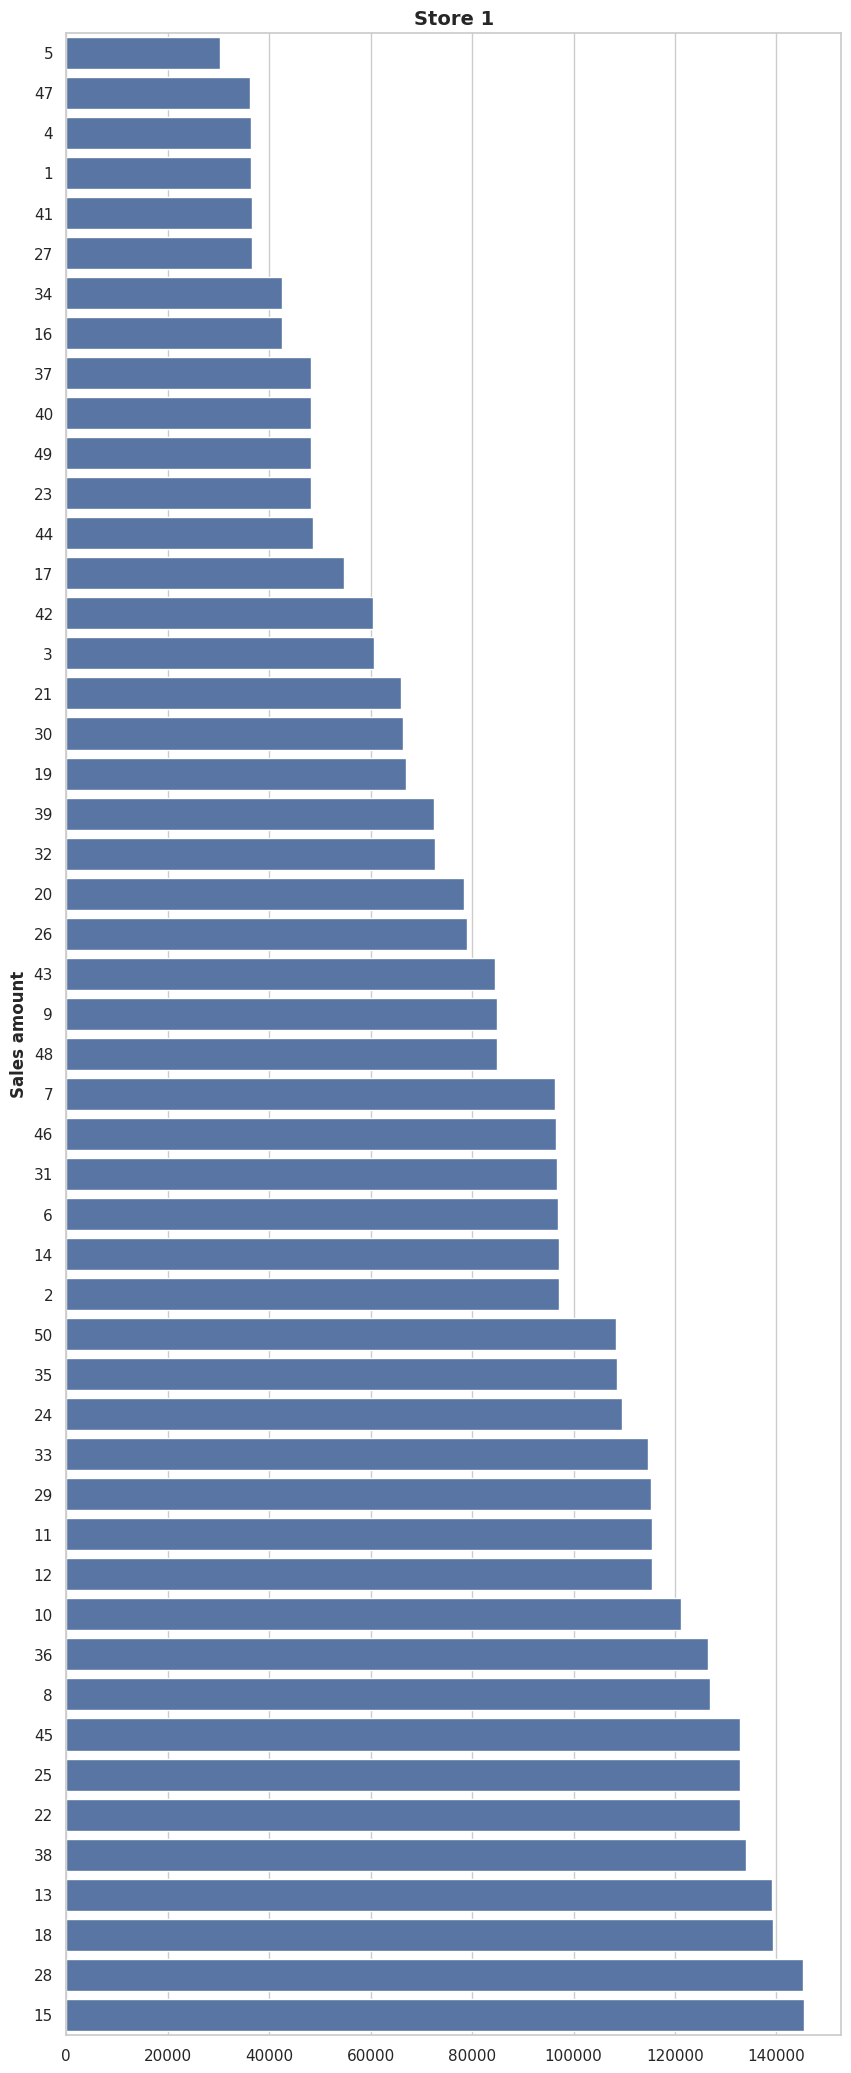

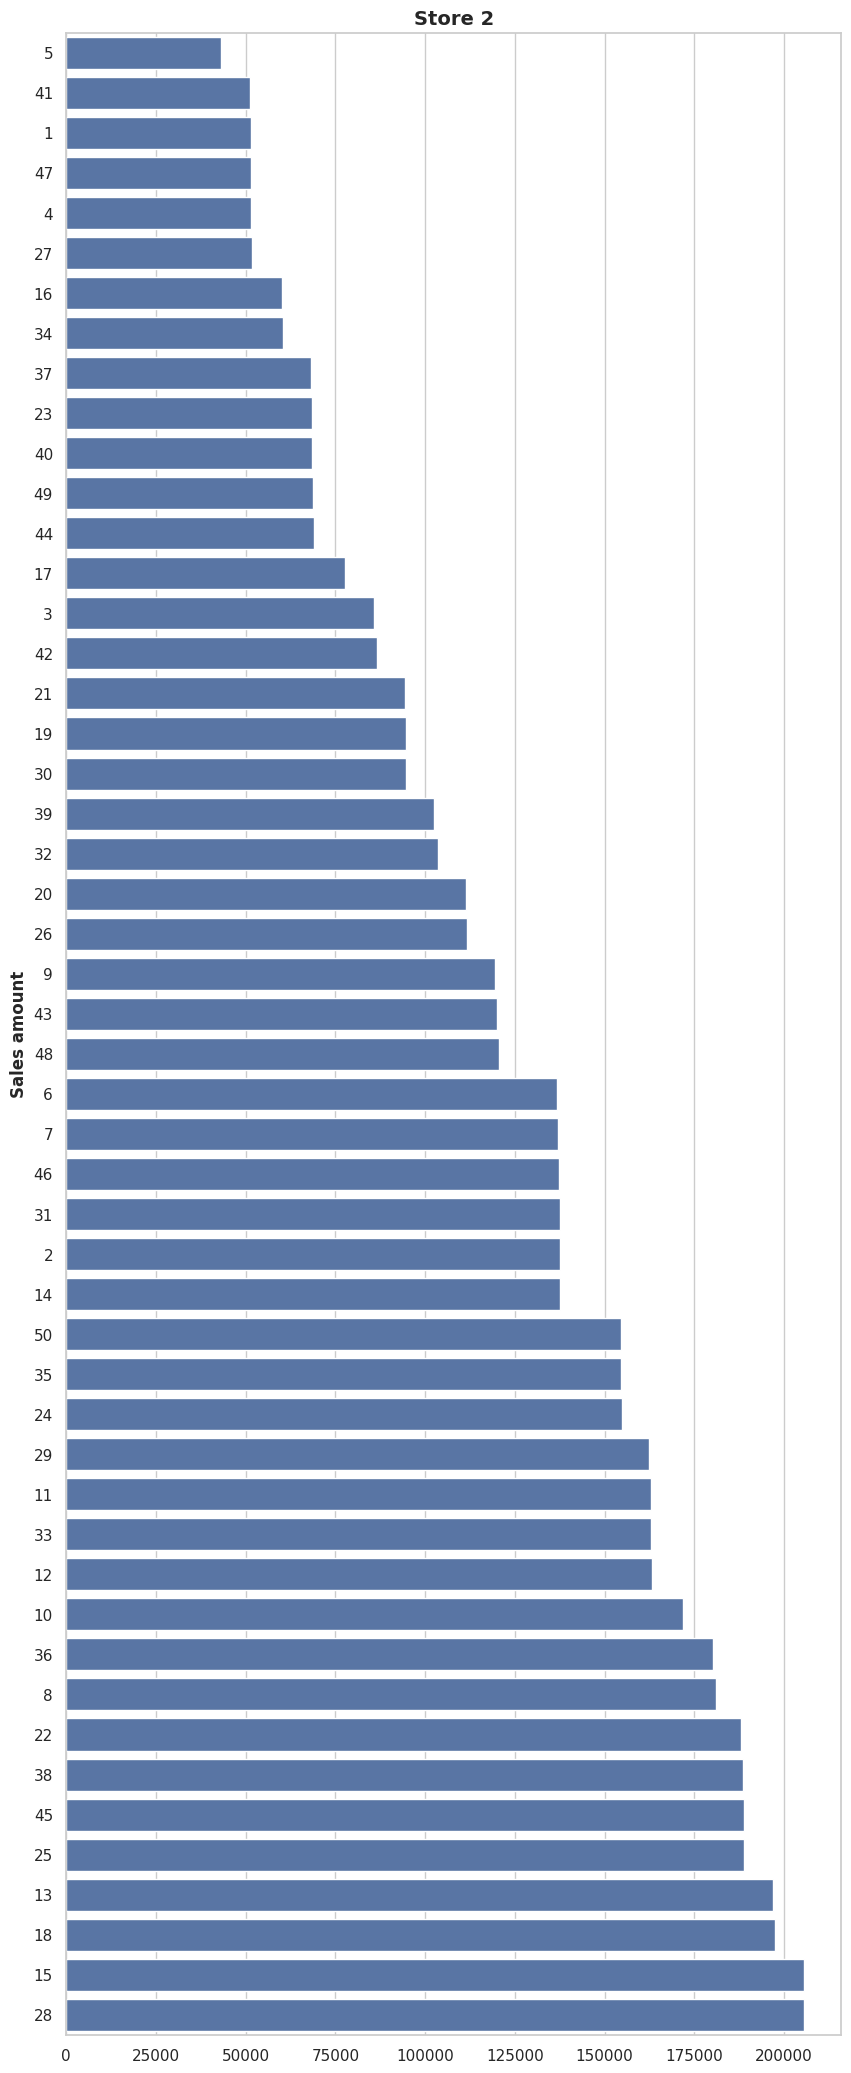

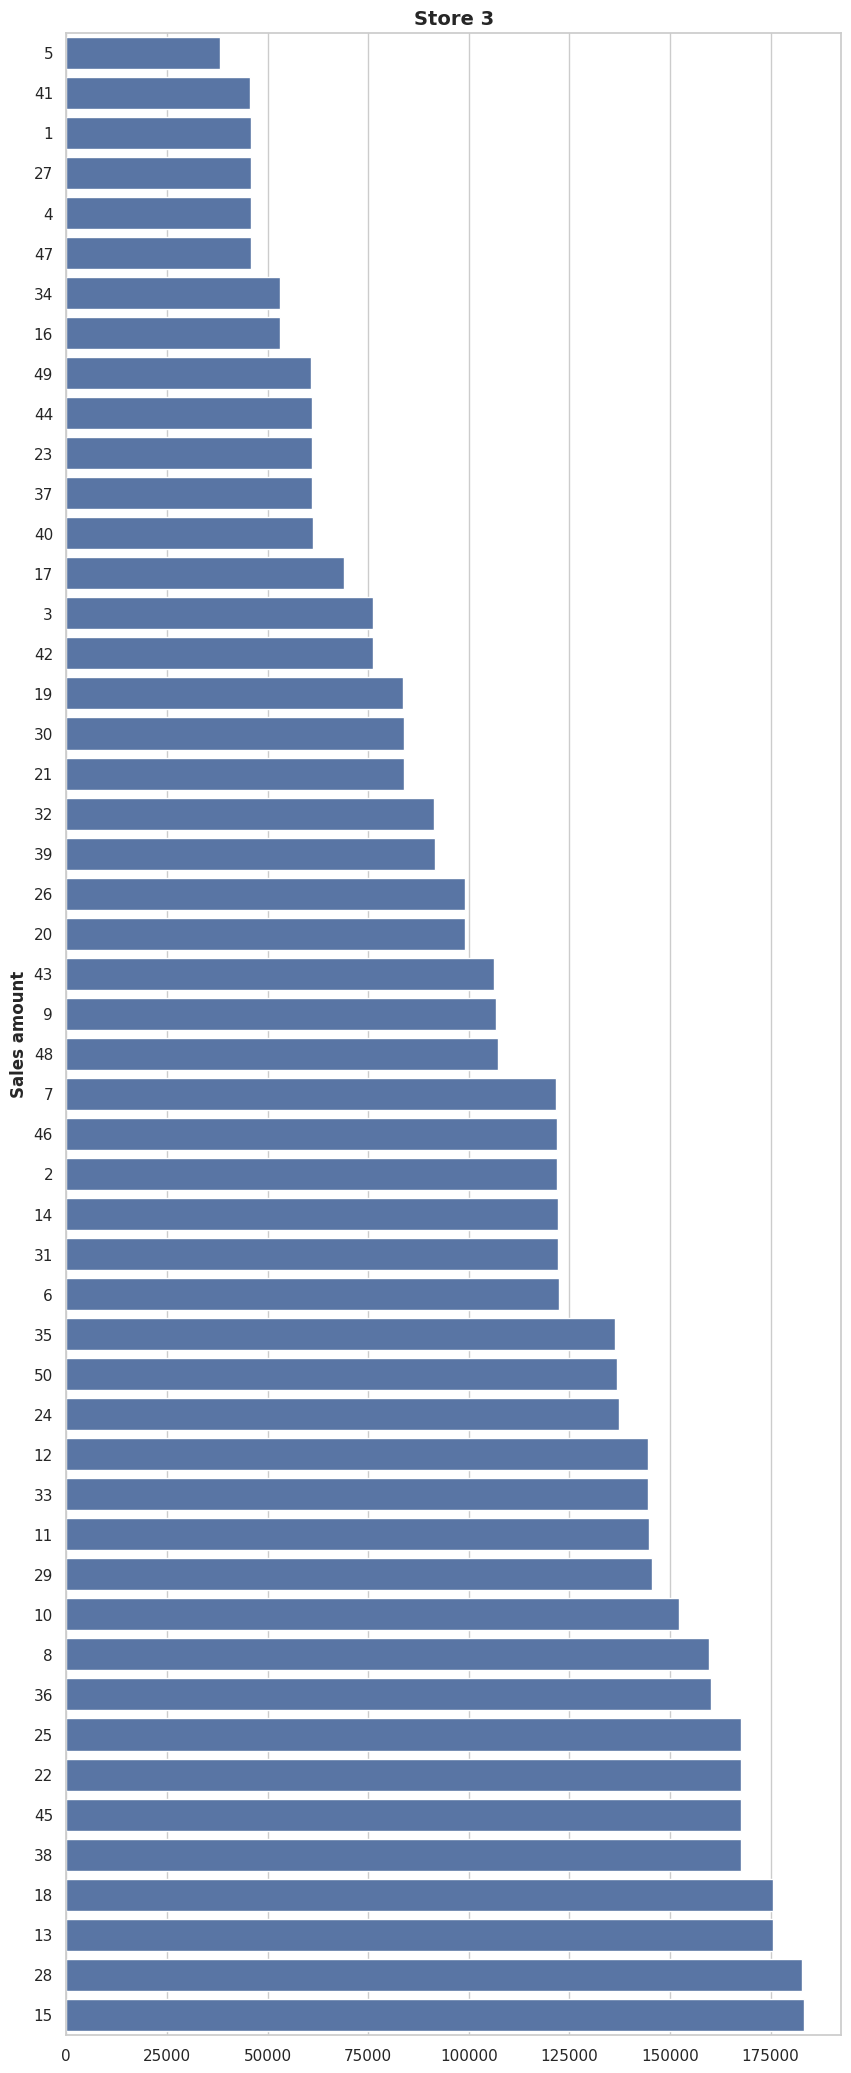

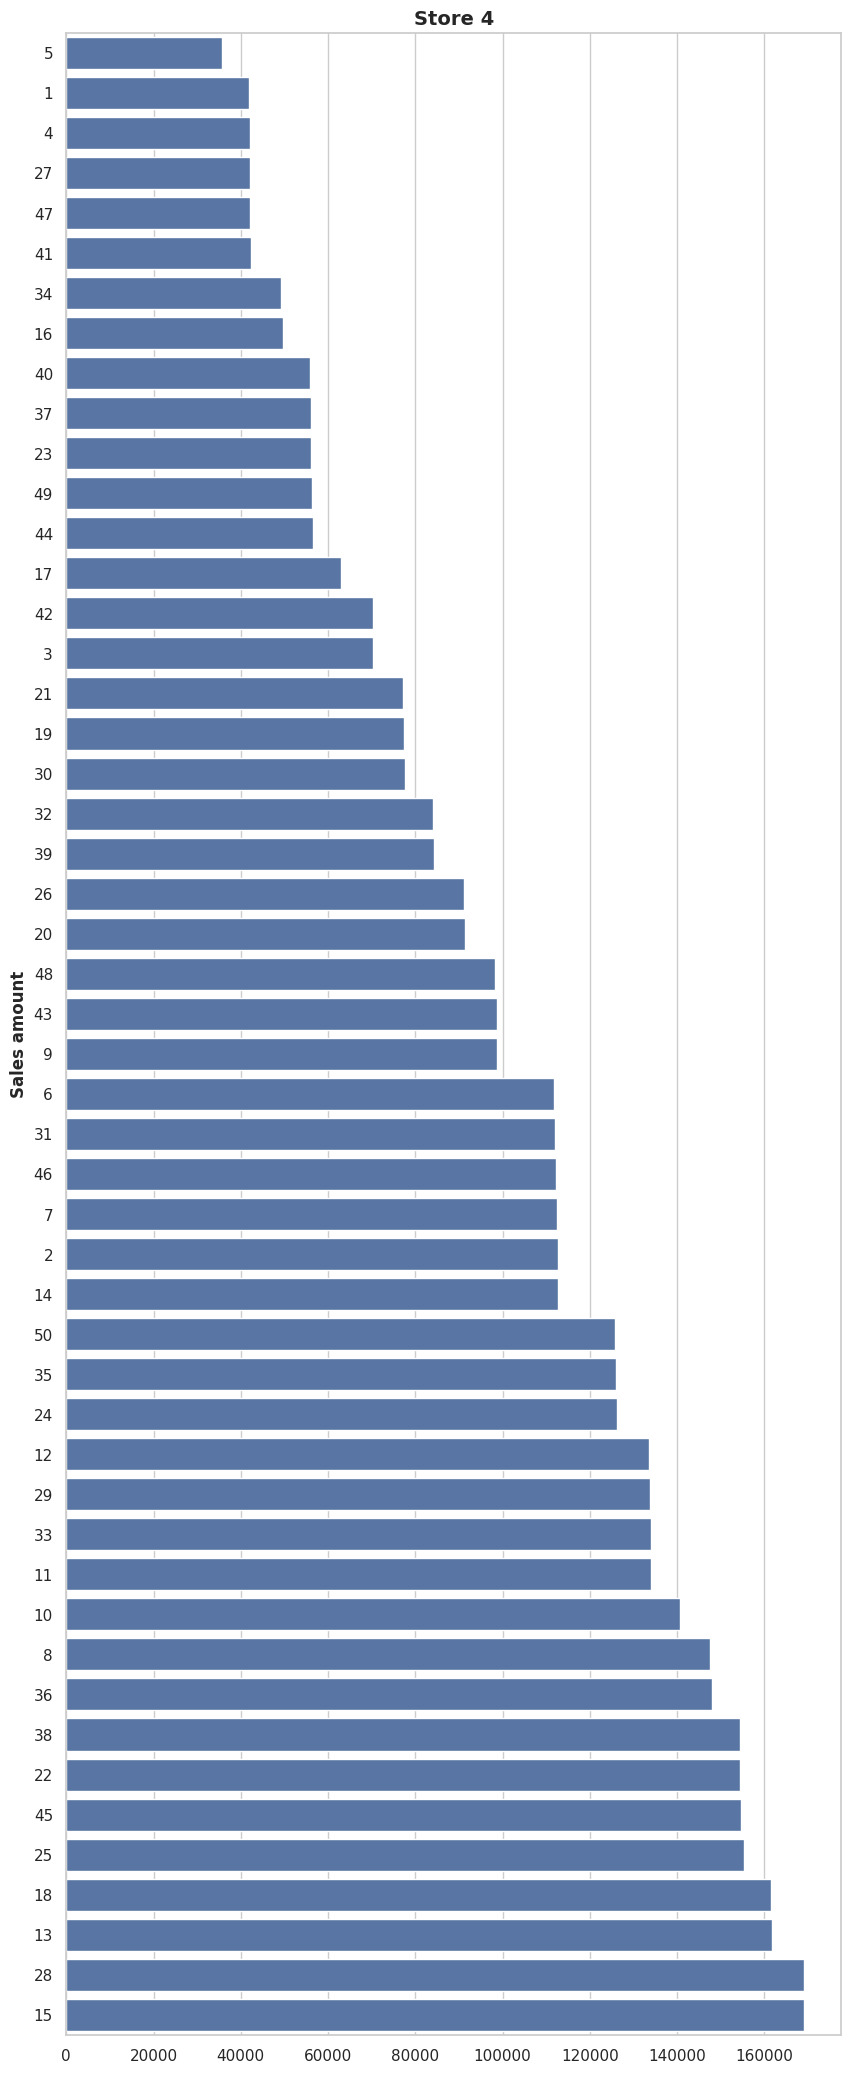

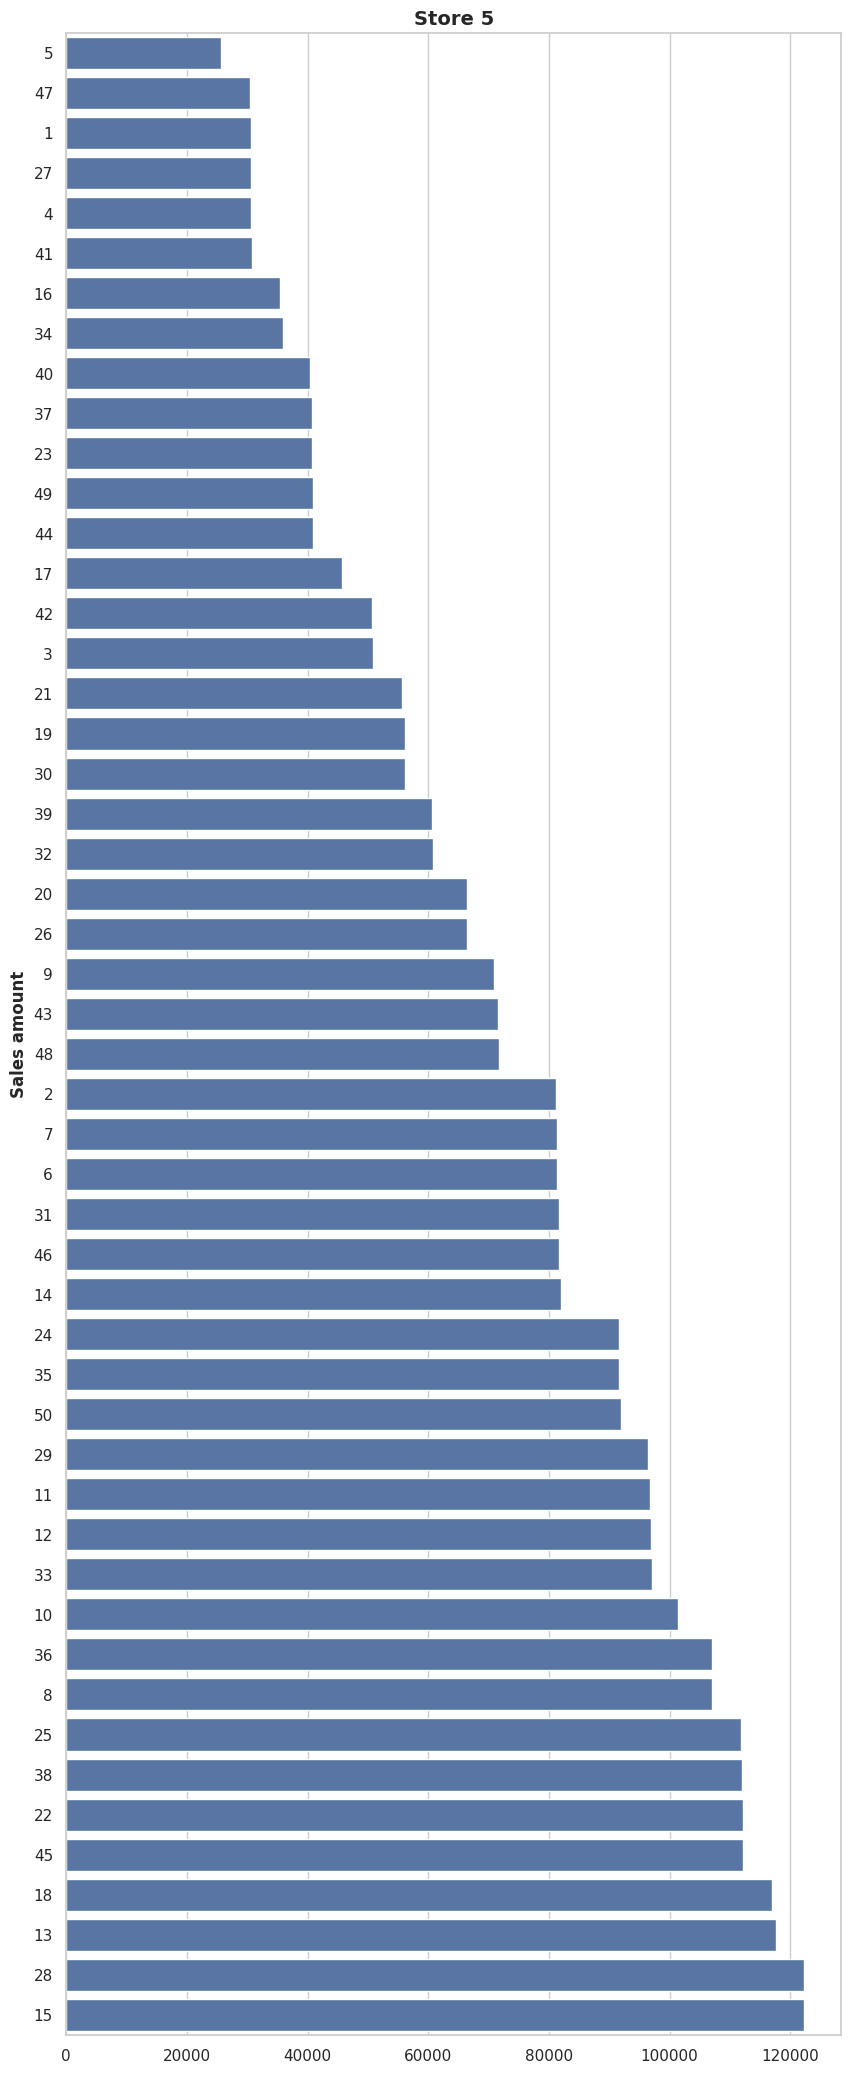

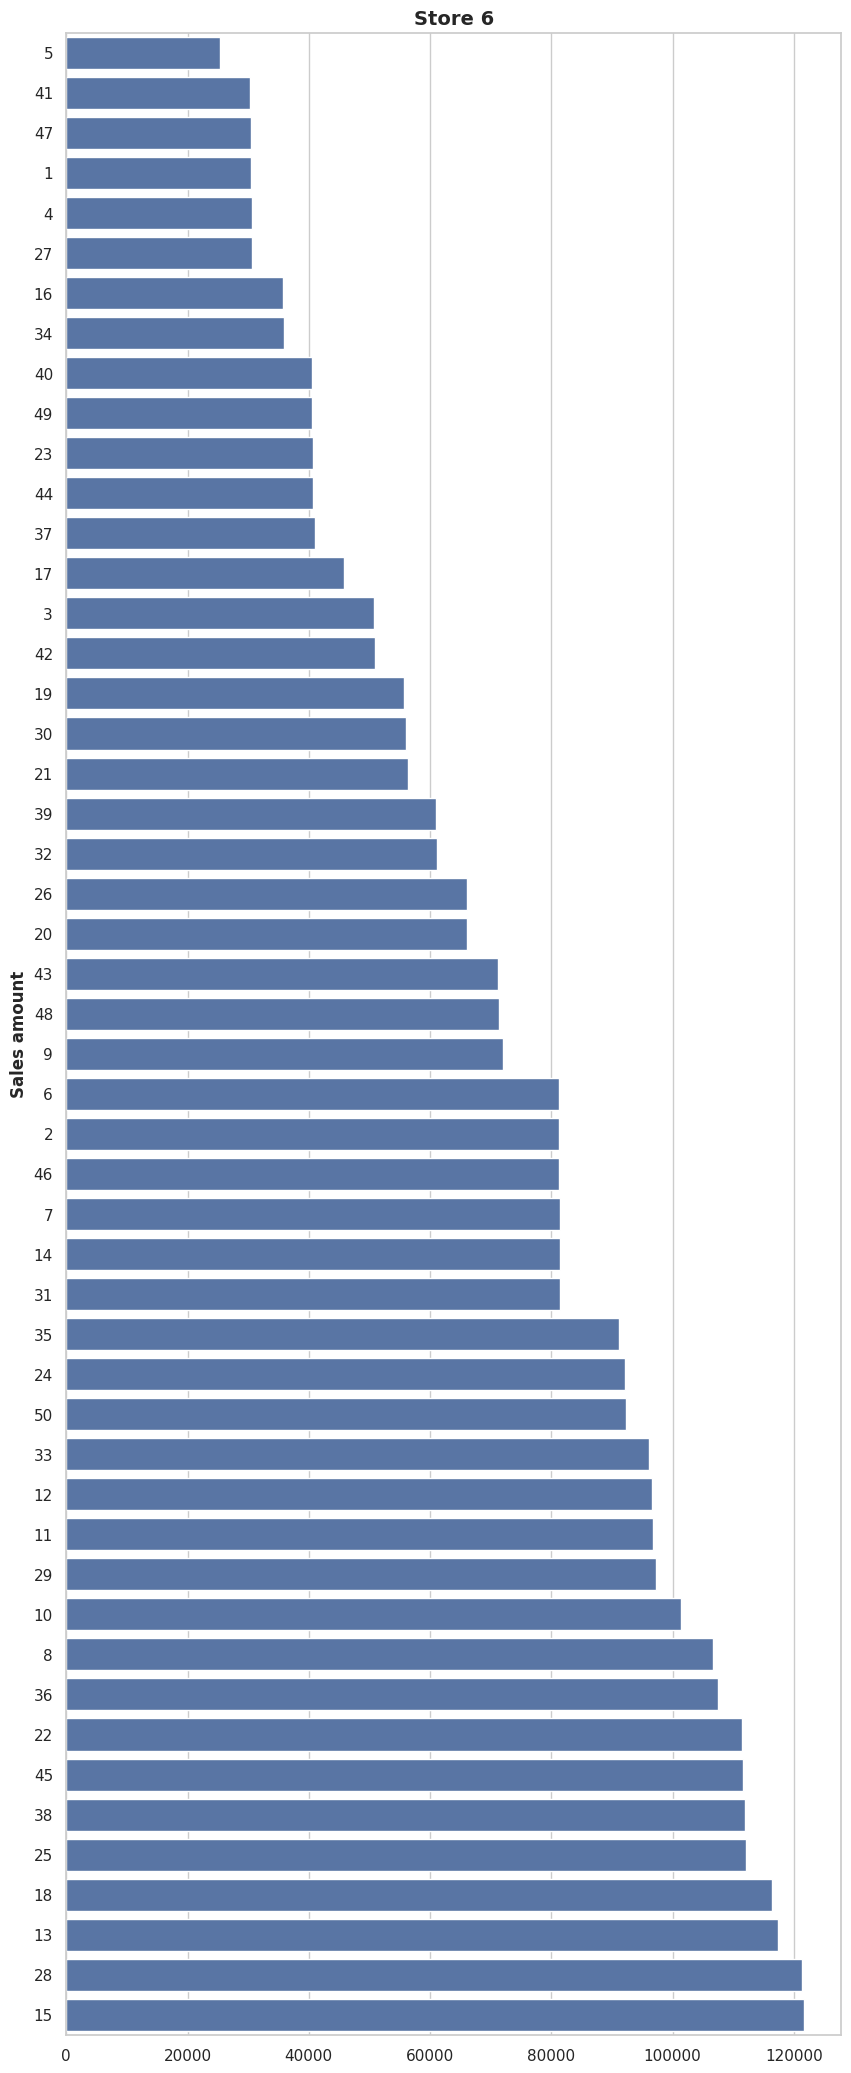

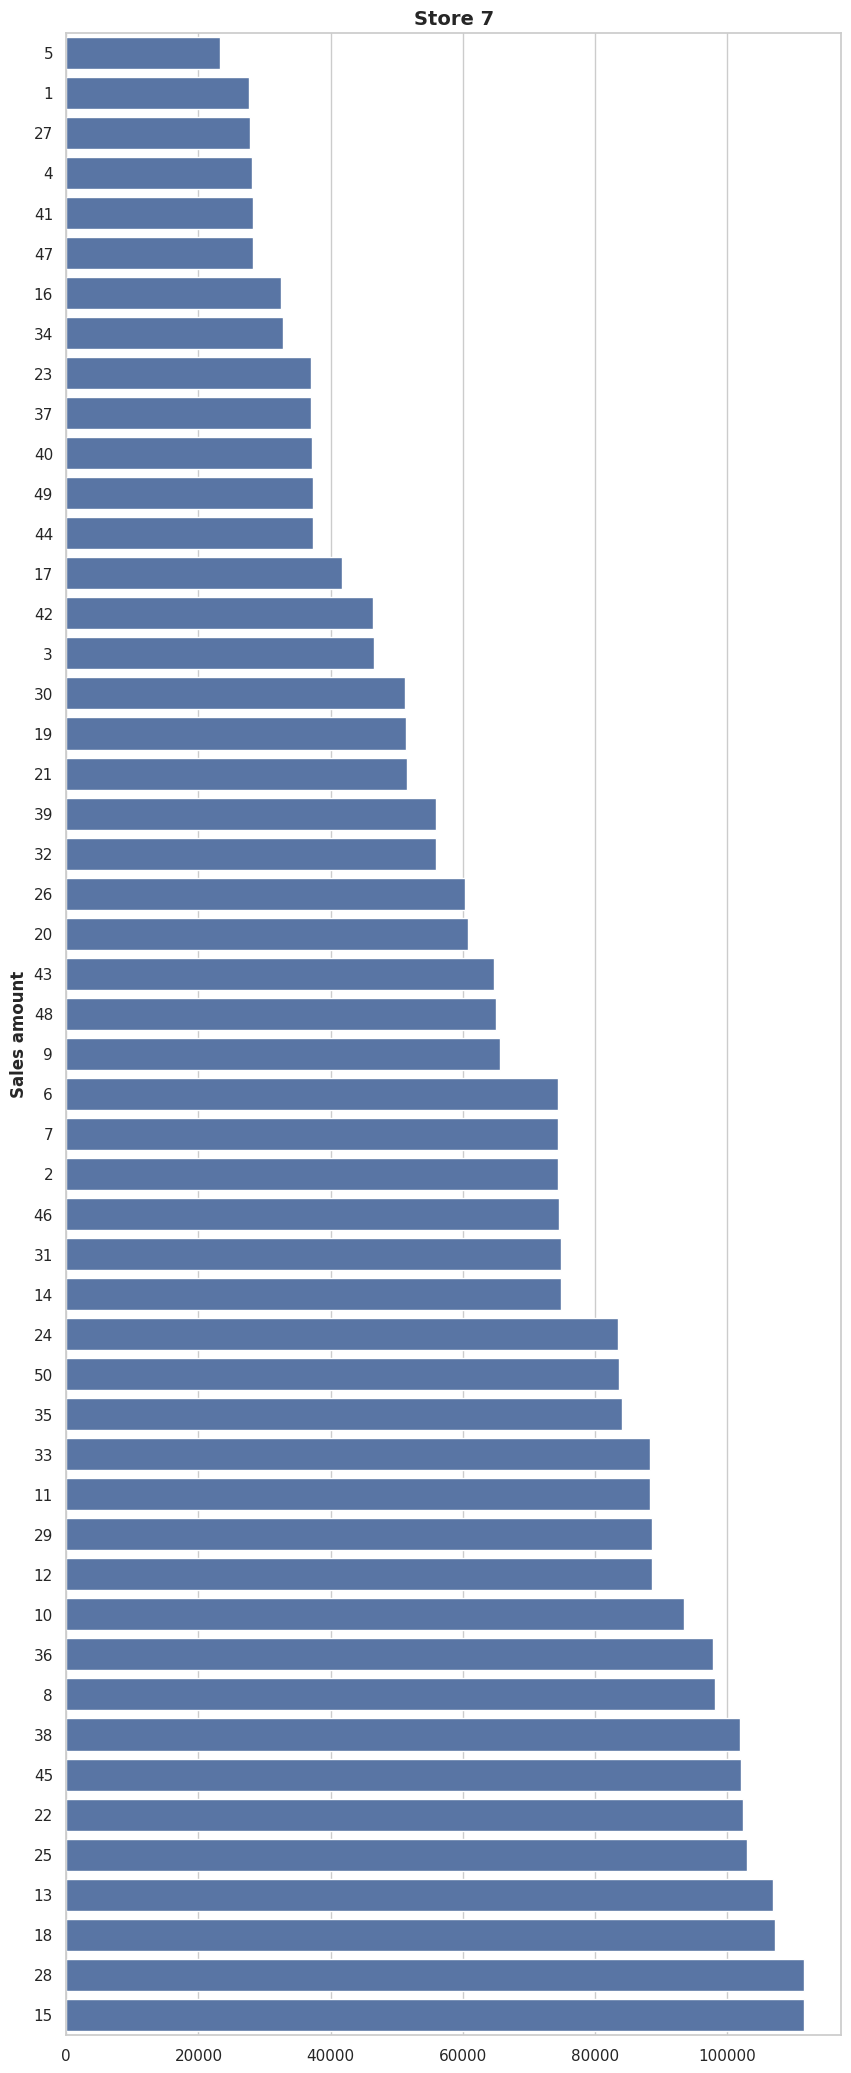

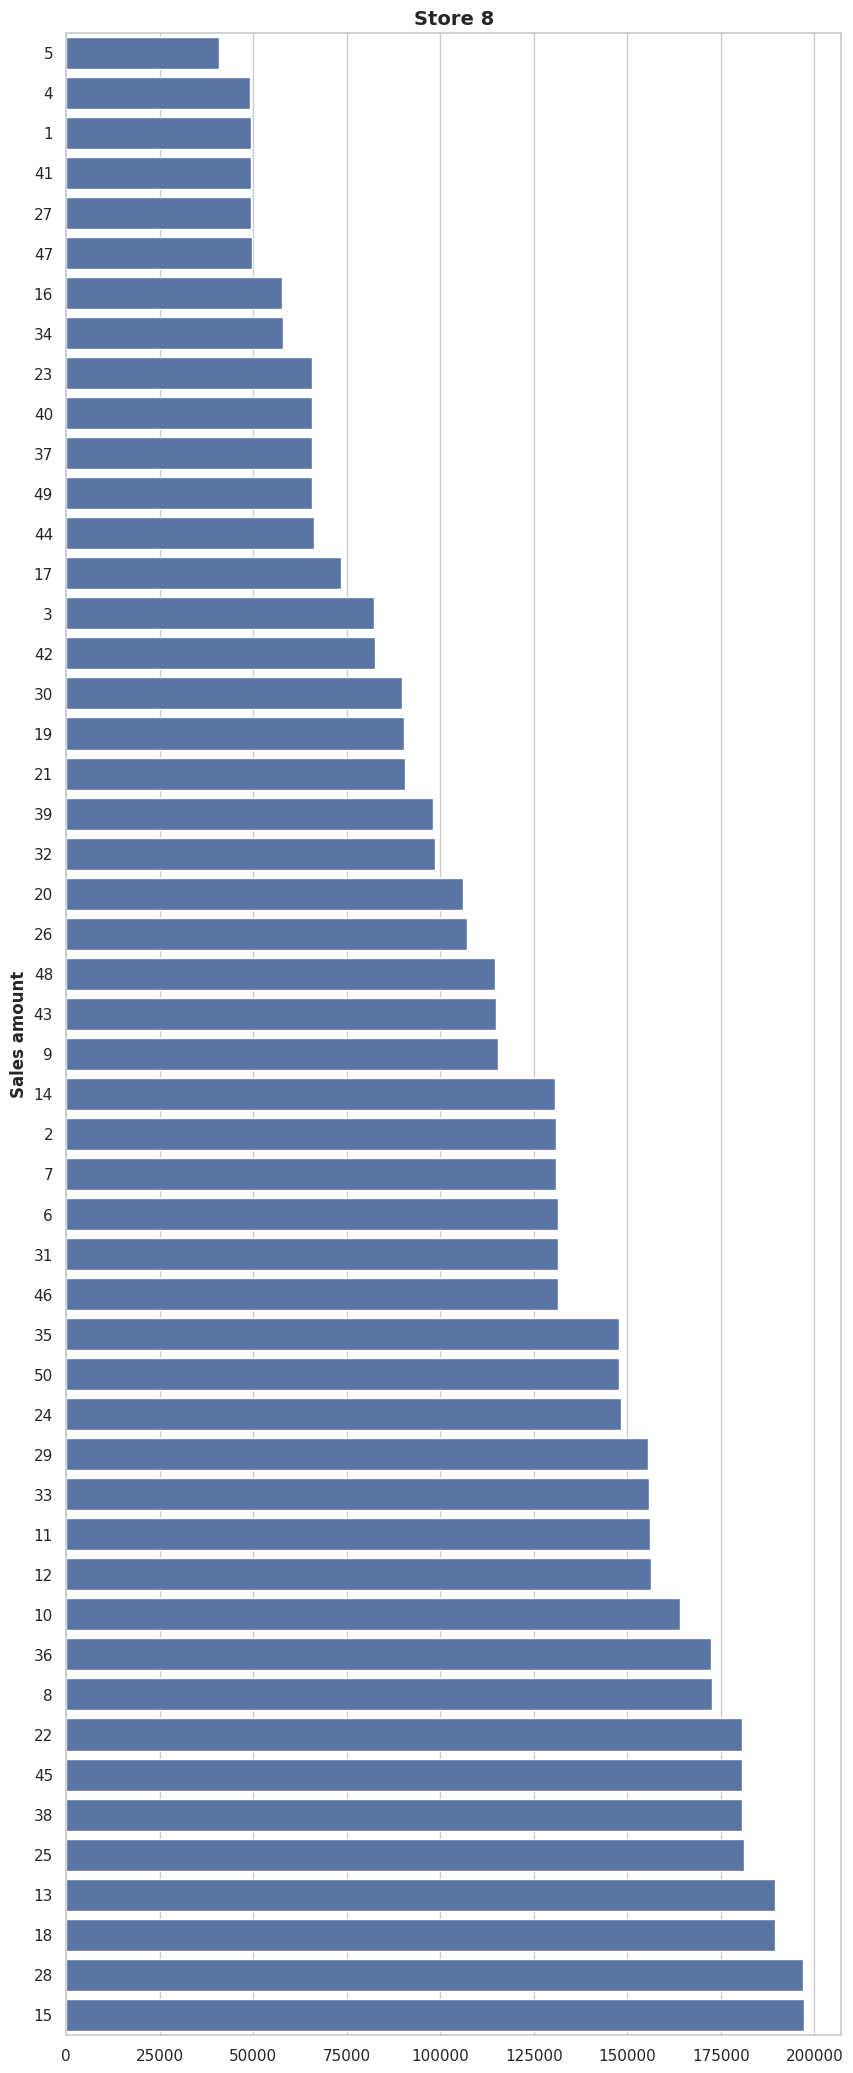

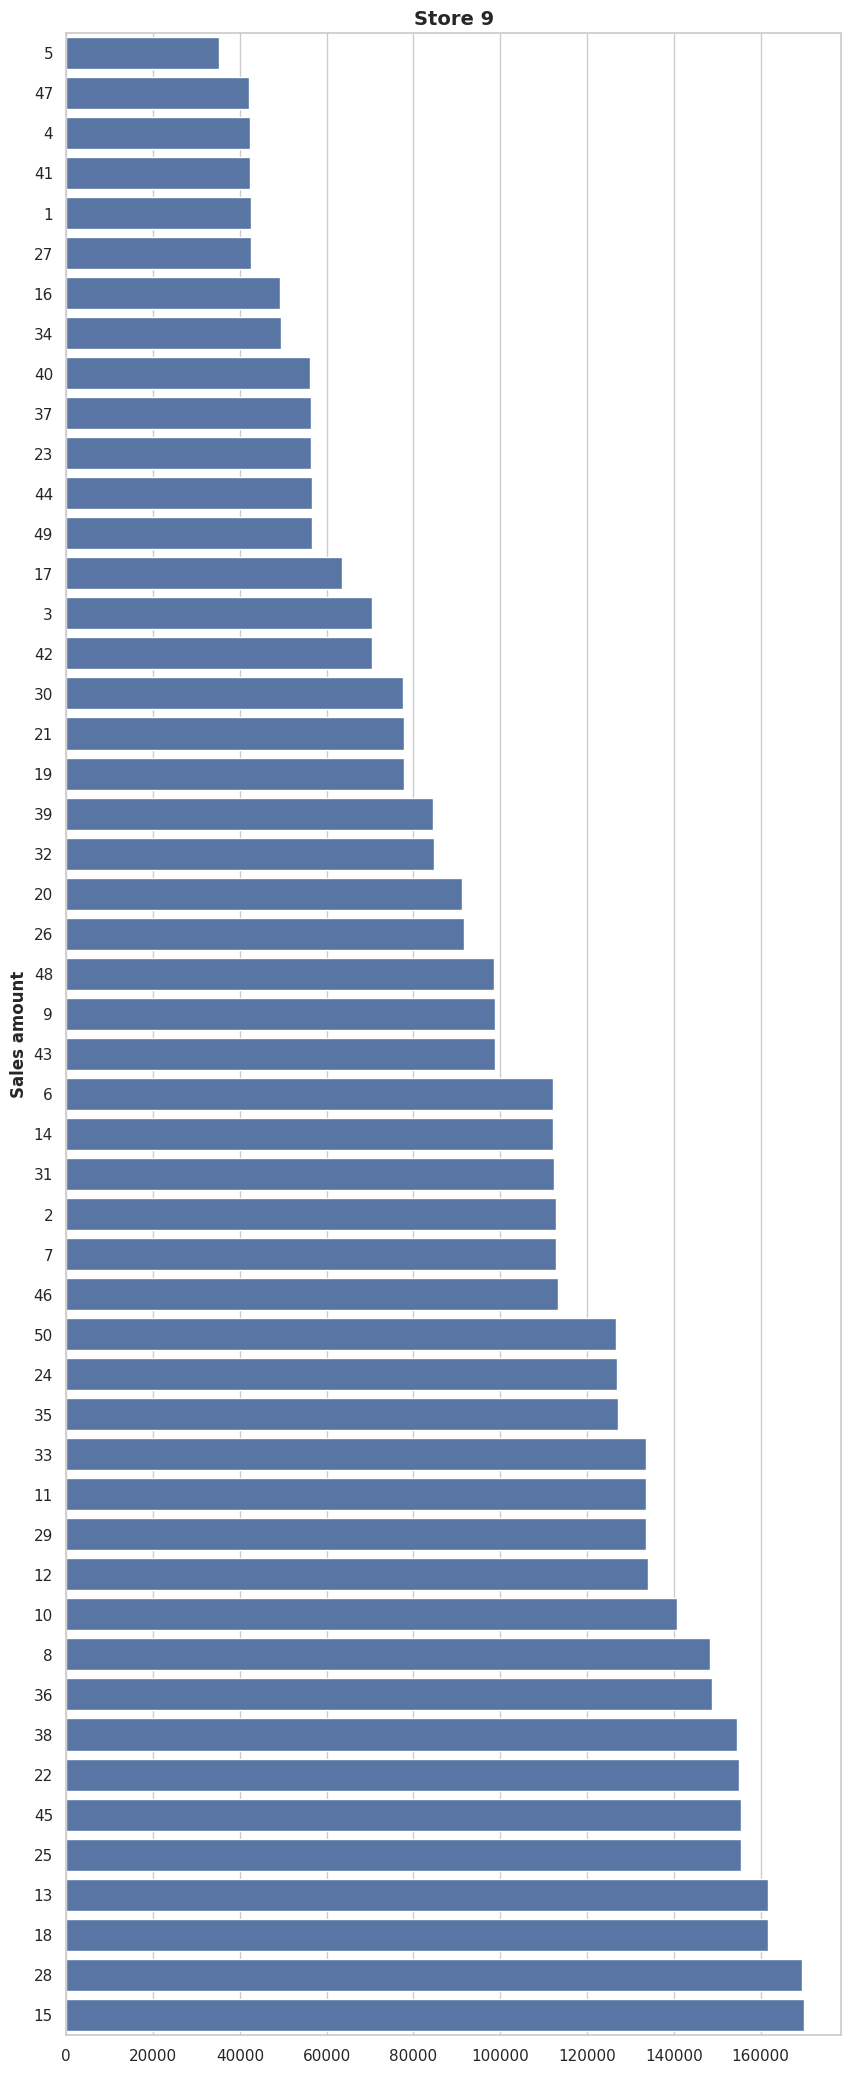

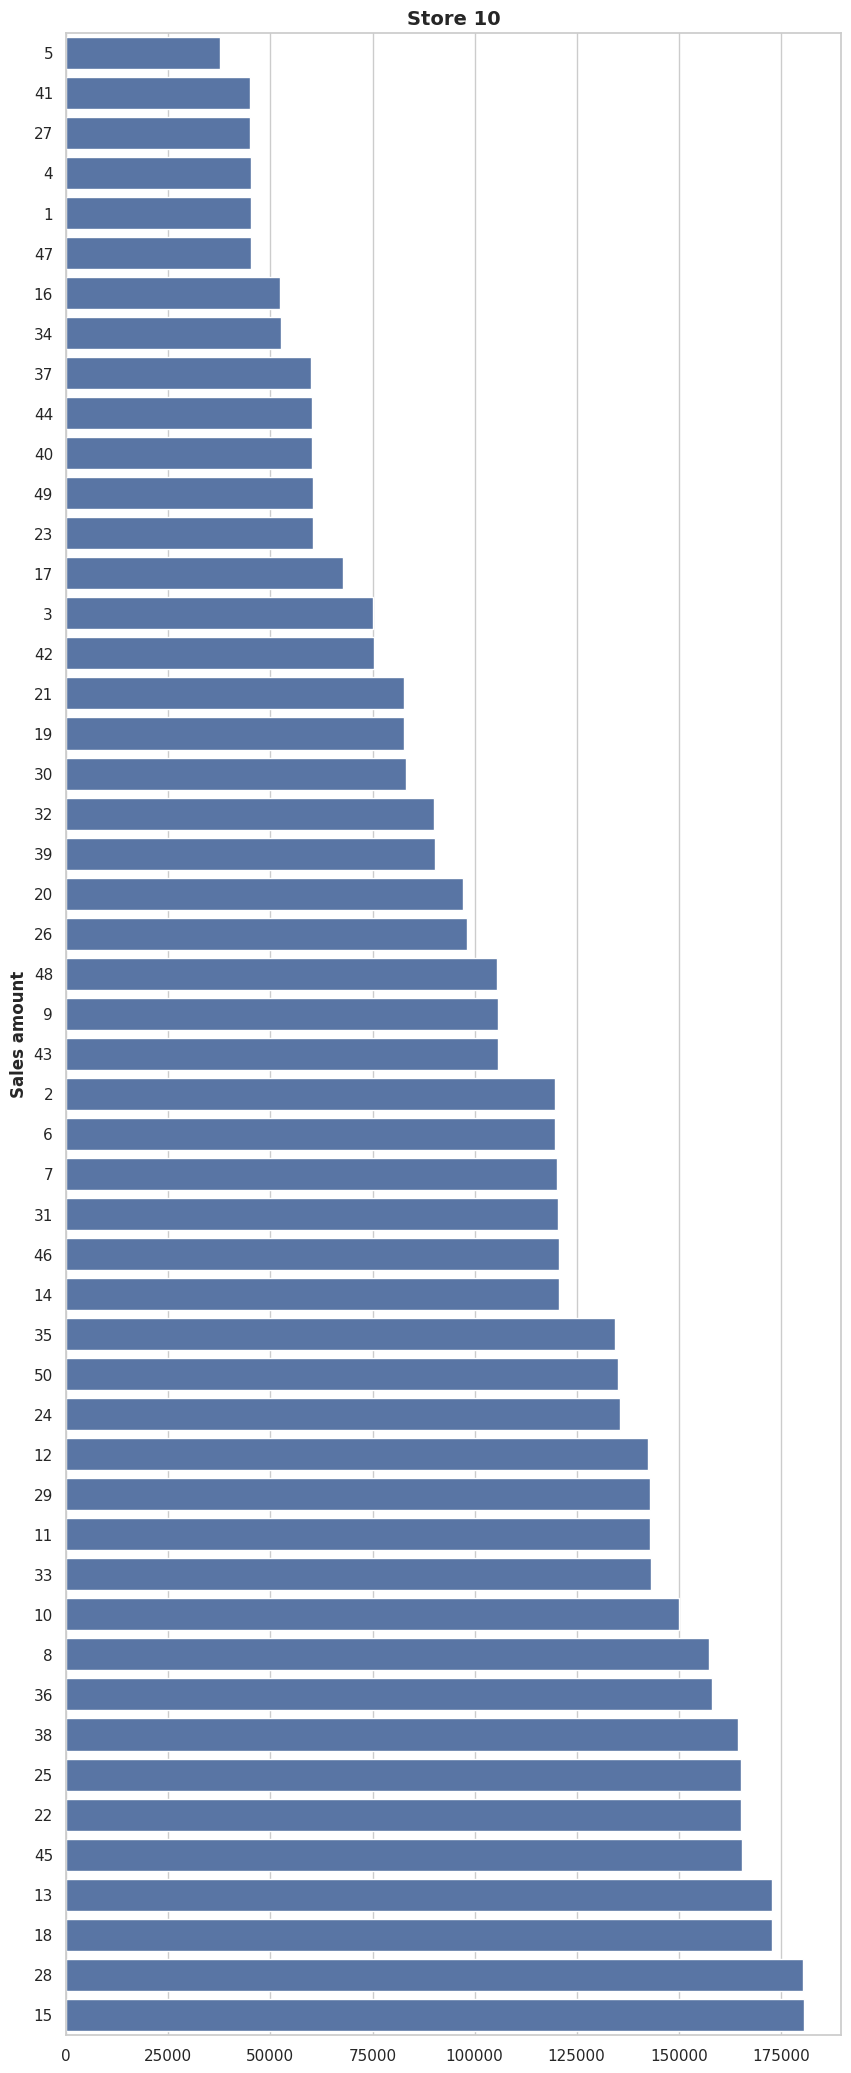

In [4]:
import seaborn as sns

sns.set_theme(style="whitegrid")

for i in range(10):

    test_df = train_df[train_df["store"] == i + 1]
    test_df = test_df.reset_index()
    test_df = test_df.groupby("item", as_index=False)["sales"].sum()
    sorted_df = test_df.sort_values(by="sales", ascending=True)

    sorted_df["item"] = sorted_df["item"].astype("category").cat.reorder_categories(sorted_df["item"], ordered=True)

    plt.figure(figsize=(10,26))

    sns.barplot(x="sales", y="item", legend=False, data=sorted_df)
    plt.ylabel("Sales amount")
    plt.xlabel("")
    plt.title(f"Store {i + 1}", fontsize=14, weight='bold')

    plt.show()

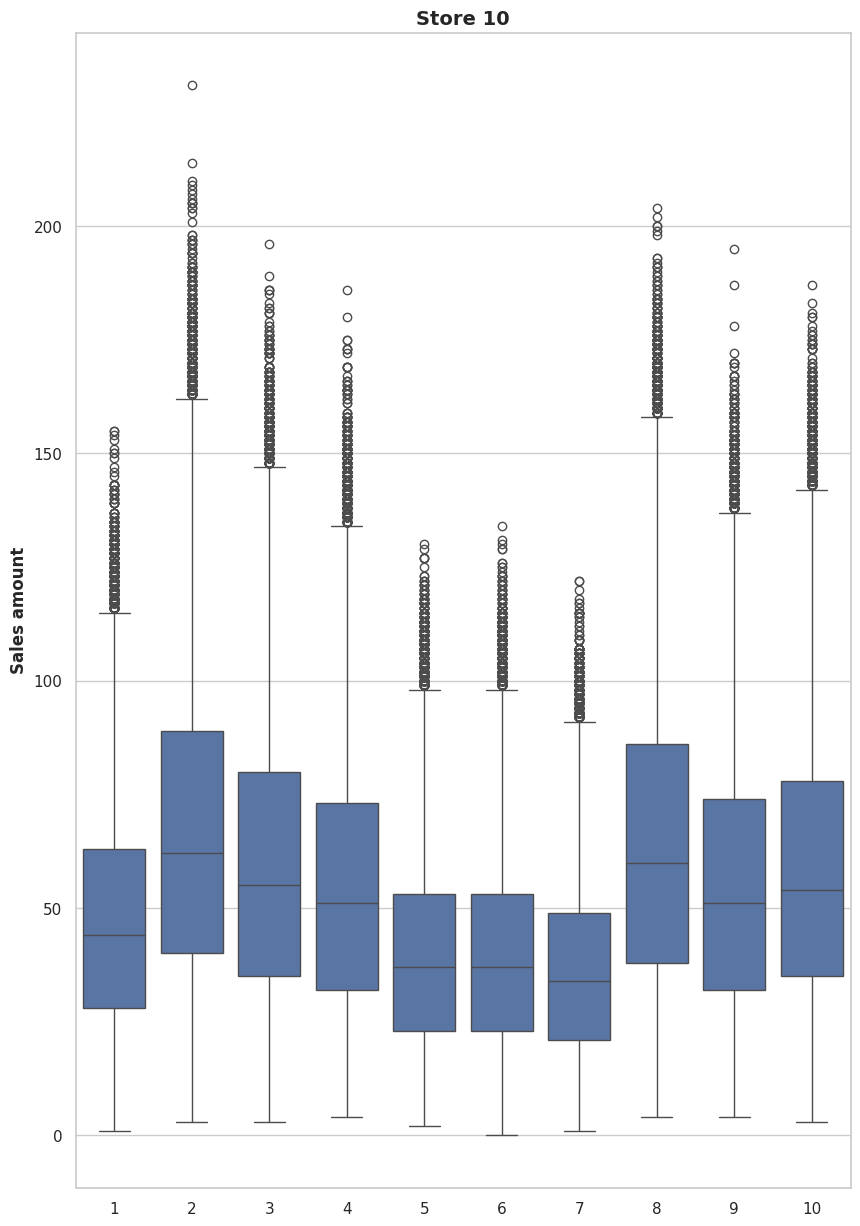

In [5]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,15))

sns.boxplot(x="store", y="sales", legend=False, data=train_df)
plt.ylabel("Sales amount")
plt.xlabel("")
plt.title(f"Store {i + 1}", fontsize=14, weight='bold')

plt.show()

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

<Axes: xlabel='date'>

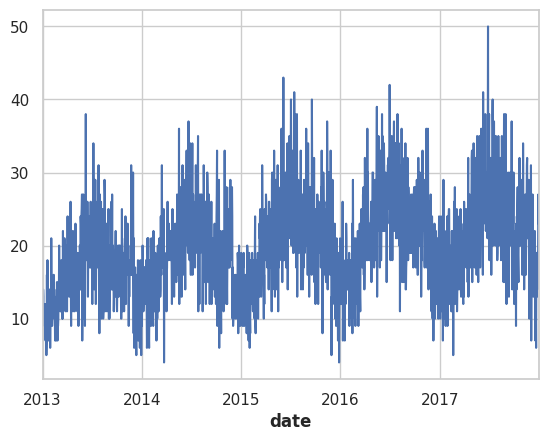

In [6]:
store_one = train_df["store"] == 1
item_one = train_df["item"] == 1

filtered_df = train_df.loc[store_one & item_one]

filtered_df["sales"].plot()

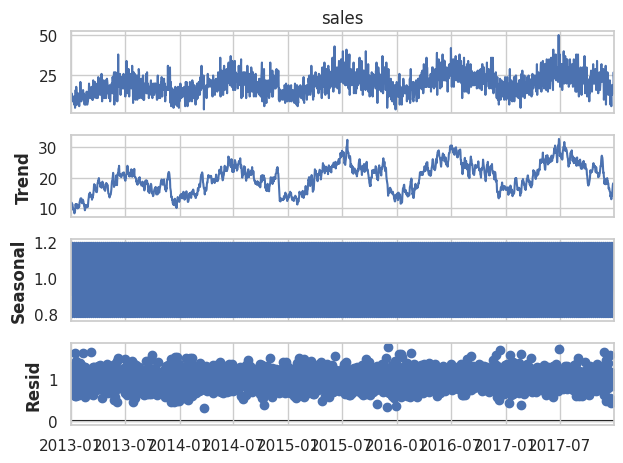

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_plot_multi = seasonal_decompose(filtered_df['sales'],
                                              model='multiplicative')
decomposition_plot_multi.plot()
plt.show()

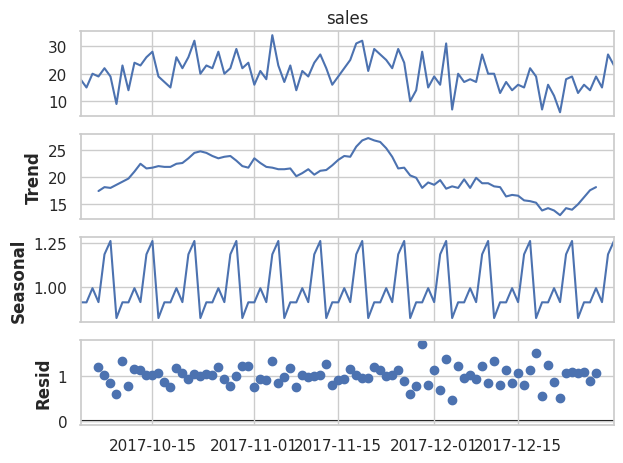

In [9]:
decomposition_plot_multi_short = seasonal_decompose(filtered_df[-90:]['sales'],
                                              model='multiplicative')
decomposition_plot_multi_short.plot()
plt.show()

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [10]:
series = TimeSeries.from_dataframe(filtered_df, value_cols='sales')

series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [11]:
train,val = series.split_before(pd.Timestamp("2017-10-01"))

val

<TimeSeries (DataArray) (date: 92, component: 1, sample: 1)> Size: 736B
array([[[21.]],

       [[12.]],

       [[18.]],

       [[15.]],

       [[20.]],

       [[19.]],

       [[22.]],

       [[19.]],

       [[ 9.]],

       [[23.]],

...

       [[ 6.]],

       [[18.]],

       [[19.]],

       [[13.]],

       [[16.]],

       [[14.]],

       [[19.]],

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 736B 2017-10-01 2017-10-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x600 with 0 Axes>

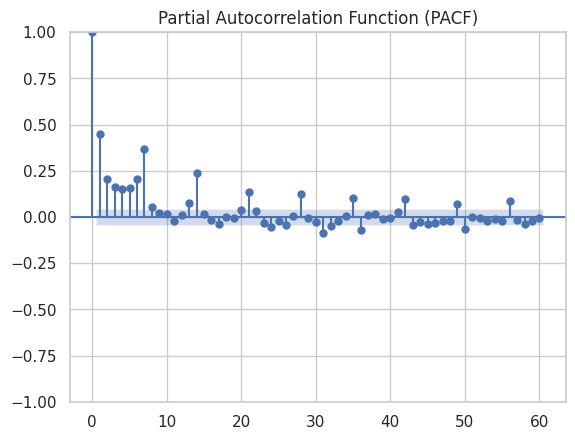

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10, 6))
plot_pacf(filtered_df["sales"], lags=60, method='ywm', )
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [15]:
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [16]:
from darts.models import NaiveDrift, NaiveSeasonal

<Axes: xlabel='date'>

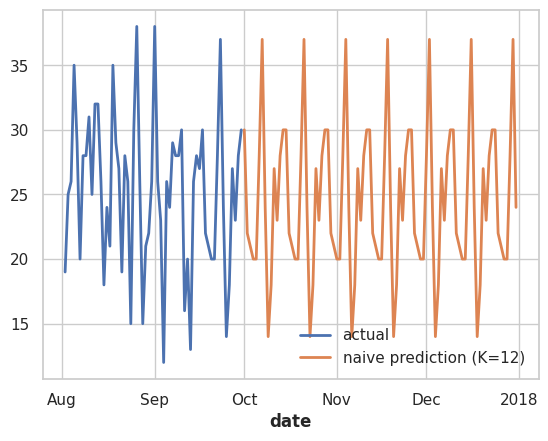

In [17]:
seasonal_model = NaiveSeasonal(K=14)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

train[-60:].plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=12)")

<Axes: xlabel='date'>

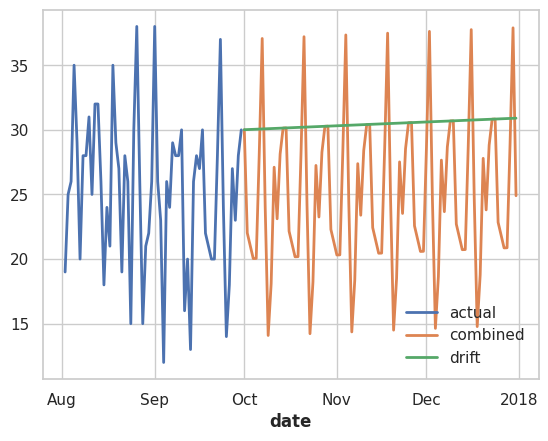

In [18]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

train[-60:].plot(label="actual")
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [20]:
from darts.metrics import mape

def eval_pred(forecast):
    print(f"Mean absolute percentage error for model: {mape(val, forecast):.2f}%.")

Mean absolute percentage error for model: 42.18%.


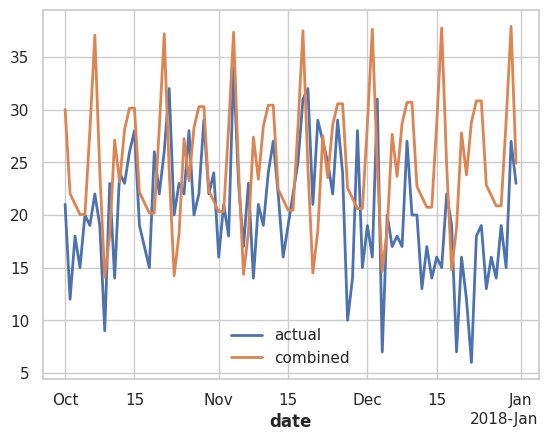

In [21]:
val.plot(label="actual")
combined_forecast.plot(label="combined")

eval_pred(combined_forecast)

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

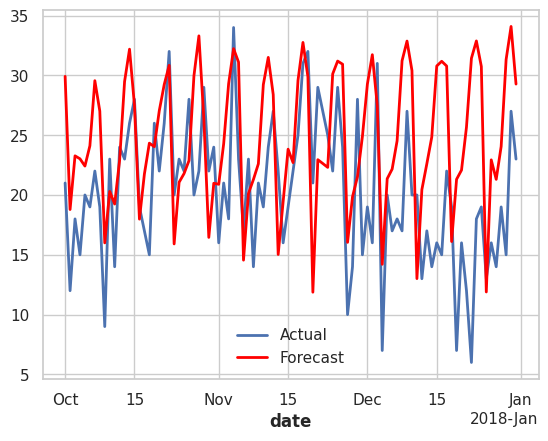

Mean absolute percentage error for model: 41.18%.


In [22]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
import numpy as np

def enrich_with_date_features(df):
  df["quarter"] = df['date'].dt.quarter
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

# Побудова моделі XGBoost
model = XGBModel(
    lags=60,
    output_chunk_length=1,
    n_estimators=400,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(train_transformed)
pred = model.predict(6)
pred.values()

forecast = scaler.inverse_transform(model.predict(len(val)))
val.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_pred(forecast)

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

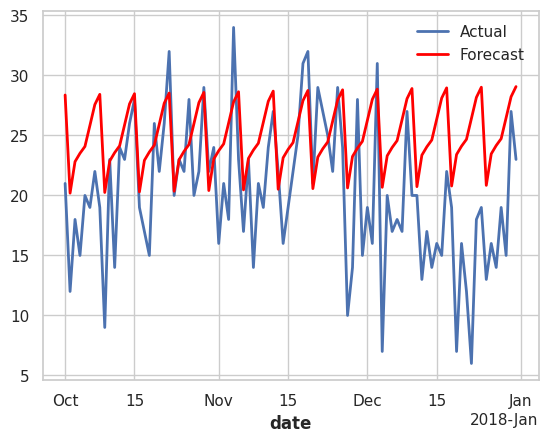

Mean absolute percentage error for model: 39.01%.


In [23]:
def plot_results(series, forecast):
  # Візуалізація результатів
  val.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_pred(forecast)

model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


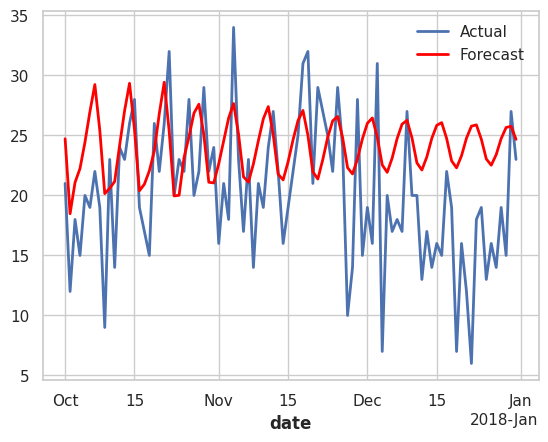

Mean absolute percentage error for model: 37.50%.


In [24]:
from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=30, d=2, q=1) # try p=12
fit_and_plot(model, series, train, val)

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

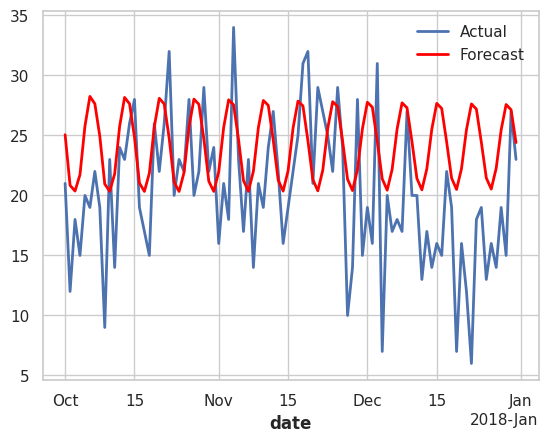

Mean absolute percentage error for model: 37.90%.


In [25]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta
model = AutoARIMA()
fit_and_plot(model, series, train, val)

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4lc7etnw/lxqw4xrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4lc7etnw/mep9r333.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60179', 'data', 'file=/tmp/tmp4lc7etnw/lxqw4xrb.json', 'init=/tmp/tmp4lc7etnw/mep9r333.json', 'output', 'file=/tmp/tmp4lc7etnw/prophet_model_d2oryjq/prophet_model-20241105171940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4l

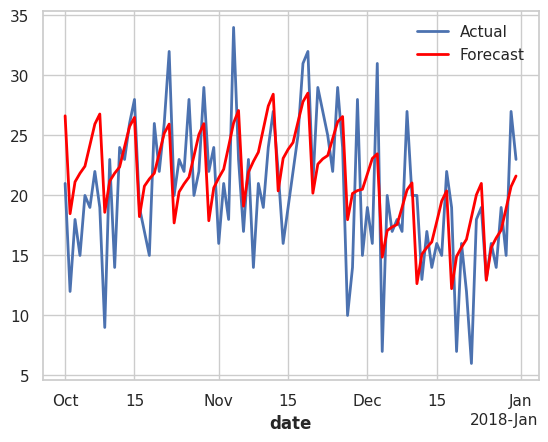

Mean absolute percentage error for model: 23.80%.


In [26]:
from darts.models import Prophet

model = Prophet()
model.fit(train)

forecast = model.predict(len(val))

fit_and_plot(model, series, train, val)

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.8 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)
7         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

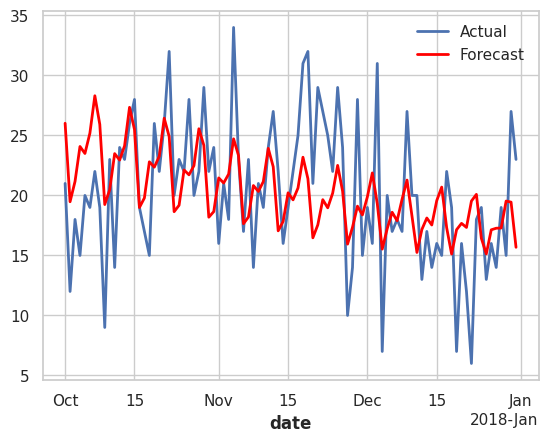

In [27]:
from darts.models import RNNModel

from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Масштабування даних
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

display(series)

# Побудова та тренування моделі LSTM
model = RNNModel(
    model="LSTM",
    input_chunk_length=14,
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    force_reset=True,
)
model.fit(
    train_transformed,
    val_series=val_transformed,
    verbose=True)

# Прогнозування
forecast = scaler.inverse_transform(model.predict(len(val)))

# Візуалізація результатів
val.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [28]:
eval_pred(forecast)

Mean absolute percentage error for model: 26.16%.


16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4lc7etnw/ng6a1awr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4lc7etnw/y84129ih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60910', 'data', 'file=/tmp/tmp4lc7etnw/ng6a1awr.json', 'init=/tmp/tmp4lc7etnw/y84129ih.json', 'output', 'file=/tmp/tmp4lc7etnw/prophet_modelxhl4eemt/prophet_model-20241105172810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4l

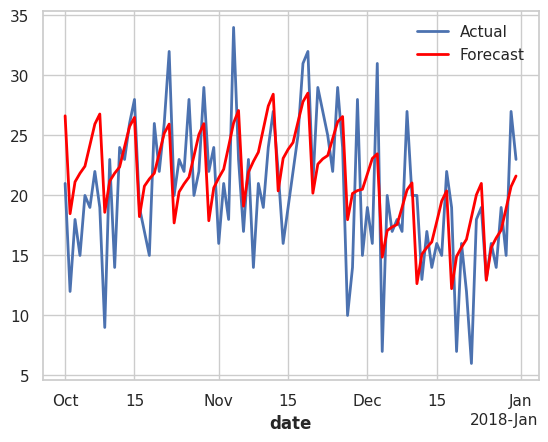

Mean absolute percentage error for model: 23.80%.


  0%|          | 0/90 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4lc7etnw/ca4nmc9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4lc7etnw/u_up142c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24109', 'data', 'file=/tmp/tmp4lc7etnw/ca4nmc9j.json', 'init=/tmp/tmp4lc7etnw/u_up142c.json', 'output', 'file=/tmp/tmp4lc7etnw/prophet_model1c4dktg5/prophet_model-20241105172812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  1%|          | 1/90 [00:00<00:33,  2.62it/s]INFO:prophet:Disabling daily seasonality. Run prophet with

MAPE = 23.09%


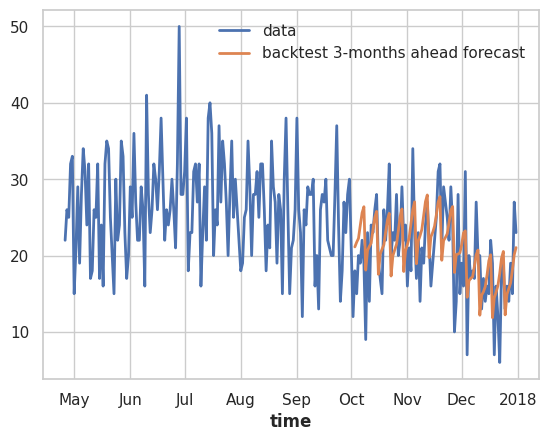

In [29]:
from darts.models import Prophet

model = Prophet()
model.fit(train)

forecast = model.predict(len(val))

fit_and_plot(model, series, train, val)

hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-10-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 3,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

series[-250:].plot(label="data")
historical_fcast.plot(label="backtest 3-months ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

  0%|          | 0/30 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4lc7etnw/bngtqazs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4lc7etnw/j2z3_tm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29530', 'data', 'file=/tmp/tmp4lc7etnw/bngtqazs.json', 'init=/tmp/tmp4lc7etnw/j2z3_tm1.json', 'output', 'file=/tmp/tmp4lc7etnw/prophet_modelrxd78rmw/prophet_model-20241105172931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  3%|▎         | 1/30 [00:00<00:17,  1.63it/s]INFO:prophet:Disabling daily seasonality. Run prophet with

MAPE = 23.54%


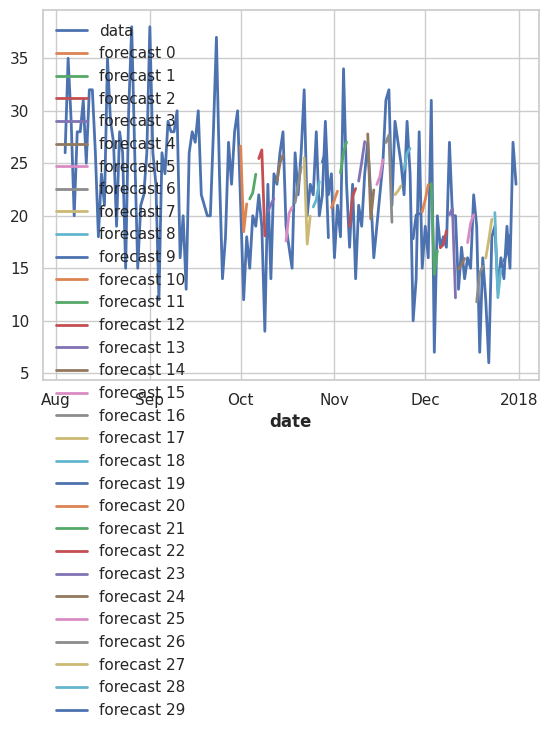

In [30]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-10-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 3,
    "verbose": True,
}

historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=3, **hfc_params)

series[-150:].plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

1) для кожного магазину та для кожної позиції можна використати окрему Prophet модель, що підвищить точність прогнозу.
2) Якщо вибирати одну модель то це XGBboost/LGBM